Note that this functionality exists in monodromy, but I could not get the coordinate normalizations to work

```python
monodromy.coordinates.mirror_monodromy_polytope
```


In [1]:
from qiskit.circuit.library import SwapGate, CXGate
from qiskit.quantum_info import random_unitary
from qiskit.extensions import UnitaryGate
from monodromy.haar import expected_cost
from qiskit.circuit.library import iSwapGate, XXPlusYYGate, CXGate
import numpy as np
from monodromy.render import gates_to_coverage_plot
from monodromy.haar import expected_cost
from monodromy.coverage import coverage_lookup_cost
import h5py
import json
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
import scienceplots
import LovelyPlots.utils as lp
from tqdm import tqdm

# %matplotlib widget

In [2]:
class ErrorModel:
    """Use exponential decay error model.

    Define fidelity model as some function of (time) cost.
    """

    def __init__(self, unit_fidelity=0.99):
        """Unit fidelity is the fidelity of operation with unit cost 1.0

        NOTE: simple convention is that CX, iSWAP have unit cost 1.0, then
        sqrt(CX) and sqrt(iSWAP) have unit cost 0.5, etc.
        """
        assert 0 <= unit_fidelity and unit_fidelity <= 1
        self.unit_fidelity = unit_fidelity
        self.normalized_lifetime = -1.0 / np.log(unit_fidelity)

    def fidelity(self, cost):
        """Convert (time) cost to fidelity"""
        return np.exp(-cost / self.normalized_lifetime)

    def infidelity(self, cost):
        """Convert (time) cost to infidelity"""
        return 1 - self.fidelity(cost)


# ErrorModel(0.99).fidelity(1.5)

In [22]:
indx = 4.0
U = iSwapGate().power(1 / indx)
safe_basis_str = f"sqrt_{indx}_iswap"
basis_str = r"$\sqrt[" + f"{indx}" + r"]{\texttt{iSWAP}}$"
basis_cost = 1.0 / indx

unit_fidelity = 0.99
affine_error_model = ErrorModel(unit_fidelity=unit_fidelity)

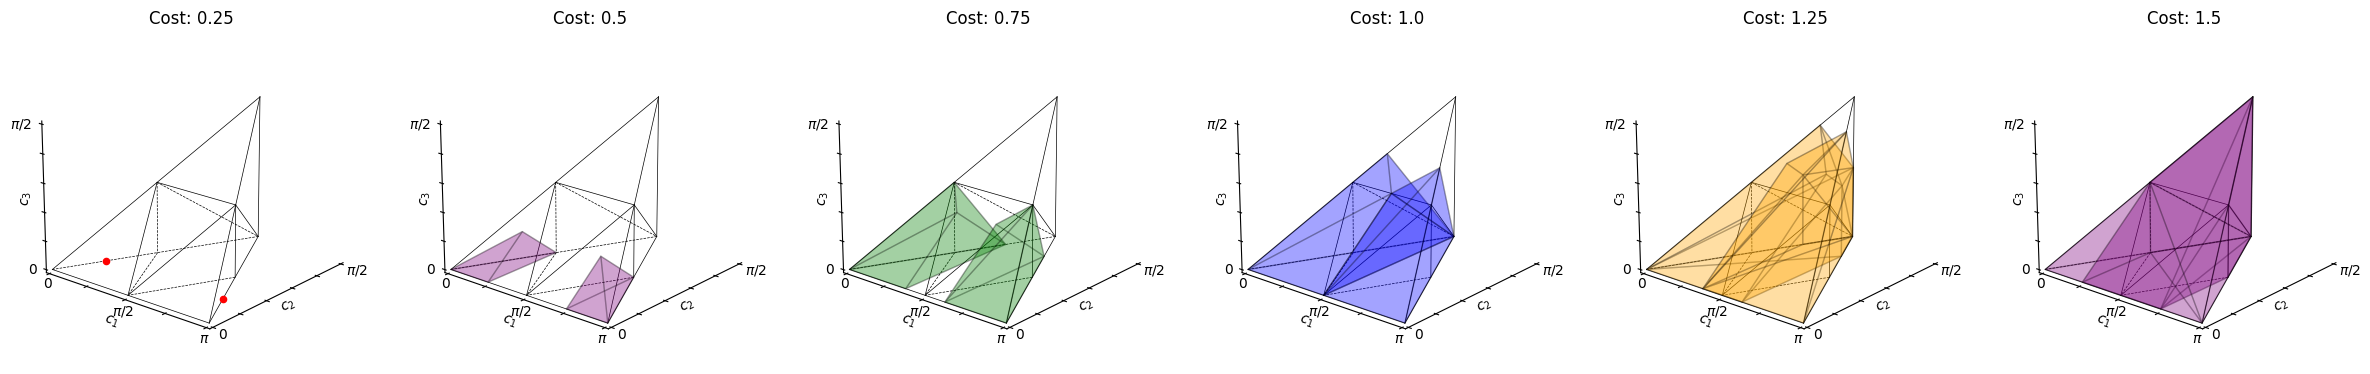

0.9598936659817359
0.9903991317415004


In [25]:
coverage_1 = gates_to_coverage_plot(U, costs=[basis_cost])
no_mirror_haar_exact = expected_cost(coverage_1)
print(no_mirror_haar_exact)
average_fidelity = affine_error_model.fidelity(no_mirror_haar_exact)
print(average_fidelity)

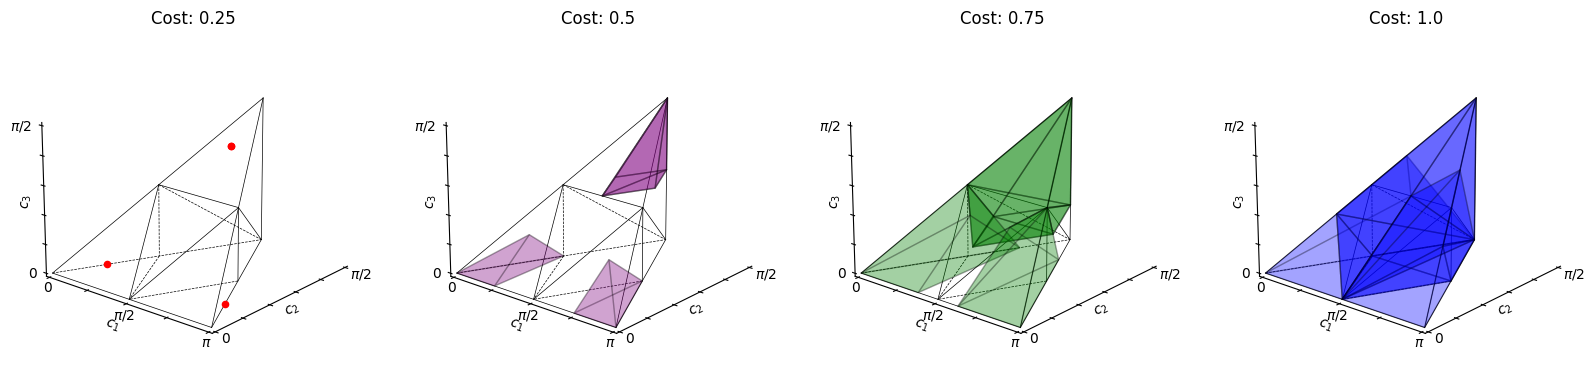

0.8996599215594611
0.9909988705446064


In [26]:
coverage_2 = gates_to_coverage_plot(U, SwapGate(), costs=[basis_cost, 0])
mirror_haar_exact = expected_cost(coverage_2)
print(mirror_haar_exact)
average_fidelity = affine_error_model.fidelity(mirror_haar_exact)
print(average_fidelity)

In [79]:
def data_collection(coverage_set, error_model, allow_approx, N=1000, save_to=None):
    """Collects data for Haar score calculations.

    Args:
        coverage_set (List[CircuitPolytopeData]): List of coverage sets.
        error_model (ErrorModel): Error model to use for cost calculation.
        allow_approx (bool): Whether to allow approximate decomposition.
        N (int, optional): Number of iterations. Defaults to 1000.
        check_every (int, optional): Check the running average every `check_every` iterations. Defaults to 100.
        save_to (str, optional): Path to the HDF5 file to save the data. If None, data won't be saved. Defaults to None.

    Returns:
        dict: Collected data.
    """
    costs = []
    running_avgs = []
    conf_intervals = []
    fidelities = []

    progress_bar = tqdm(total=N, desc="Starting")

    for _ in range(N):
        target = UnitaryGate(random_unitary(4))
        # NOTE fidelity here is circuit cost and decomposition fidelity combined
        cost, fidelity = coverage_lookup_cost(
            coverage_set, target, error_model, allow_approx=allow_approx
        )
        costs.append(cost)
        fidelities.append(fidelity)
        running_avgs.append(np.mean(costs))

        if len(np.unique(costs)) > 1:
            confidence = 0.95
            conf_interval = stats.t.interval(
                confidence, len(costs) - 1, loc=np.mean(costs), scale=stats.sem(costs)
            )
            conf_intervals.append(conf_interval)
        else:
            conf_intervals.append((np.nan, np.nan))

        if len(np.unique(costs)) > 1:
            progress_bar.set_description(
                f"Current average cost: {running_avgs[-1]:.4f}, Std. Error: {stats.sem(costs):.4f}"
            )
        else:
            progress_bar.set_description(
                f"Current average cost: {running_avgs[-1]:.4f}"
            )
        progress_bar.update()

    progress_bar.close()

    # print frequency of each cost
    print(Counter(costs))
    print("Monte Carlo: Haar score", np.mean(costs))

    # print average fidelity
    print("Monte Carlo: Average fidelity", np.mean(fidelities))

    data = {
        "costs": costs,
        "running_avgs": running_avgs,
        "conf_intervals": conf_intervals,
        "fidelities": fidelities,
    }

    if save_to is not None:
        with h5py.File(save_to, "w") as f:
            for key, value in data.items():
                f.create_dataset(key, data=json.dumps(value))

    return data

In [80]:
coverage_sets = [coverage_1, coverage_1, coverage_2, coverage_2]
allow_approx = [False, True, False, True]
mirror_flags = ["no_mirror", "no_mirror", "mirror", "mirror"]
labels = [
    "mirror_data/"
    + rf"{mirror_flag}-{safe_basis_str}-approx{approx_bool}-{affine_error_model.unit_fidelity}"
    for mirror_flag, approx_bool in zip(mirror_flags, allow_approx)
]

In [81]:
# NOTE uncomment if want to actually run the data collection

for coverage_set, approx_bool, label in zip(coverage_sets, allow_approx, labels):
    print(f"Running: {label}")
    data_collection(
        coverage_set, affine_error_model, approx_bool, save_to=label + ".hdf5"
    )
    print("\n")

Running: mirror_data/no_mirror-sqrt_4.0_iswap-approxFalse-0.99


Current average cost: 0.9722, Std. Error: 0.0116:   8%|▊         | 80/1000 [00:00<00:01, 727.47it/s]

Current average cost: 0.9570, Std. Error: 0.0038: 100%|██████████| 1000/1000 [00:01<00:00, 613.39it/s]


Counter({1.0: 770, 0.75: 186, 1.25: 34, 0.5: 10})
Monte Carlo: Haar score 0.957
Monte Carlo: Average fidelity 0.9904286558982722


Running: mirror_data/no_mirror-sqrt_4.0_iswap-approxTrue-0.99


Current average cost: 0.9165, Std. Error: 0.0045: 100%|██████████| 1000/1000 [1:08:04<00:00,  4.08s/it]


Counter({1.0: 645, 0.75: 304, 0.5: 27, 1.25: 24})
Monte Carlo: Haar score 0.9165
Monte Carlo: Average fidelity 0.9906416258931311


Running: mirror_data/mirror-sqrt_4.0_iswap-approxFalse-0.99


Current average cost: 0.8952, Std. Error: 0.0042: 100%|██████████| 1000/1000 [00:01<00:00, 642.18it/s]


Counter({1.0: 599, 0.75: 383, 0.5: 18})
Monte Carlo: Haar score 0.89525
Monte Carlo: Average fidelity 0.9910436681972753


Running: mirror_data/mirror-sqrt_4.0_iswap-approxTrue-0.99


Current average cost: 0.8452, Std. Error: 0.0045: 100%|██████████| 1000/1000 [2:10:36<00:00,  7.84s/it] 

Counter({0.75: 525, 1.0: 428, 0.5: 47})
Monte Carlo: Haar score 0.84525
Monte Carlo: Average fidelity 0.9913012131571044




In [82]:
def plot_data(data, labels, pretty_labels, exact_convergence=None):
    """Plots running averages and confidence intervals from data.

    Args:
        data (List[dict]): List of dictionaries containing data from each run.
        labels (List[str]): List of labels for each data set (used for exact_convergence matching).
        pretty_labels (List[str]): List of 'pretty' labels for each data set (used for plotting).
        exact_convergence (dict, optional): Dictionary containing values of exact convergence for each data set. If None, it won't be plotted. Defaults to None.
    """
    assert len(labels) == len(
        pretty_labels
    ), "Labels and pretty_labels must have the same length."

    with plt.style.context(["ieee", "science"]):
        plt.rc("text", usetex=True)
        for d, label, pretty_label in zip(data, labels, pretty_labels):
            running_avgs = d["running_avgs"]
            conf_intervals = d["conf_intervals"]
            plt.plot(running_avgs, label=f"{pretty_label}")
            # plt.fill_between(
            #     range(len(running_avgs)),
            #     [ci[0] for ci in conf_intervals],
            #     [ci[1] for ci in conf_intervals],
            #     alpha=0.1,
            # )

            if exact_convergence and label in exact_convergence:
                plt.axhline(
                    y=exact_convergence[label],
                    color="k",
                    linestyle="--",
                    alpha=0.5,
                    # label=f"Exact Convergence - {pretty_label}",
                )

        # # Extract basis gate name and error value from the first label
        # directory, label_info = labels[0].split('/')
        # basis_gate, name, error_value = label_info.split('-')

        # Use the extracted information to build the title
        # plt.title(
        #     f"Haar Score vs Iteration" #, {basis_str}, unit fidelity {unit_fidelity}"
        # )

        plt.xlabel("Iteration")
        plt.ylabel("Haar Score")
        # use log scales
        # plt.yscale("log")
        plt.xscale("log")
        # plt.legend()
        # put legend above plot in 2 columns
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.26), ncol=2)

        # shrink figure height
        plt.gcf().set_size_inches(3.5, 1.85)

        fig = plt.gcf()
        plt.show()

    # return fig so can be saved
    return fig


def load_hdf5_data(filename):
    """Load data from an HDF5 file.

    Args:
        filename (str): Path to the HDF5 file.

    Returns:
        dict: Data loaded from the file.
    """
    with h5py.File(filename, "r") as f:
        data = {key: json.loads(value[()]) for key, value in f.items()}
    return data

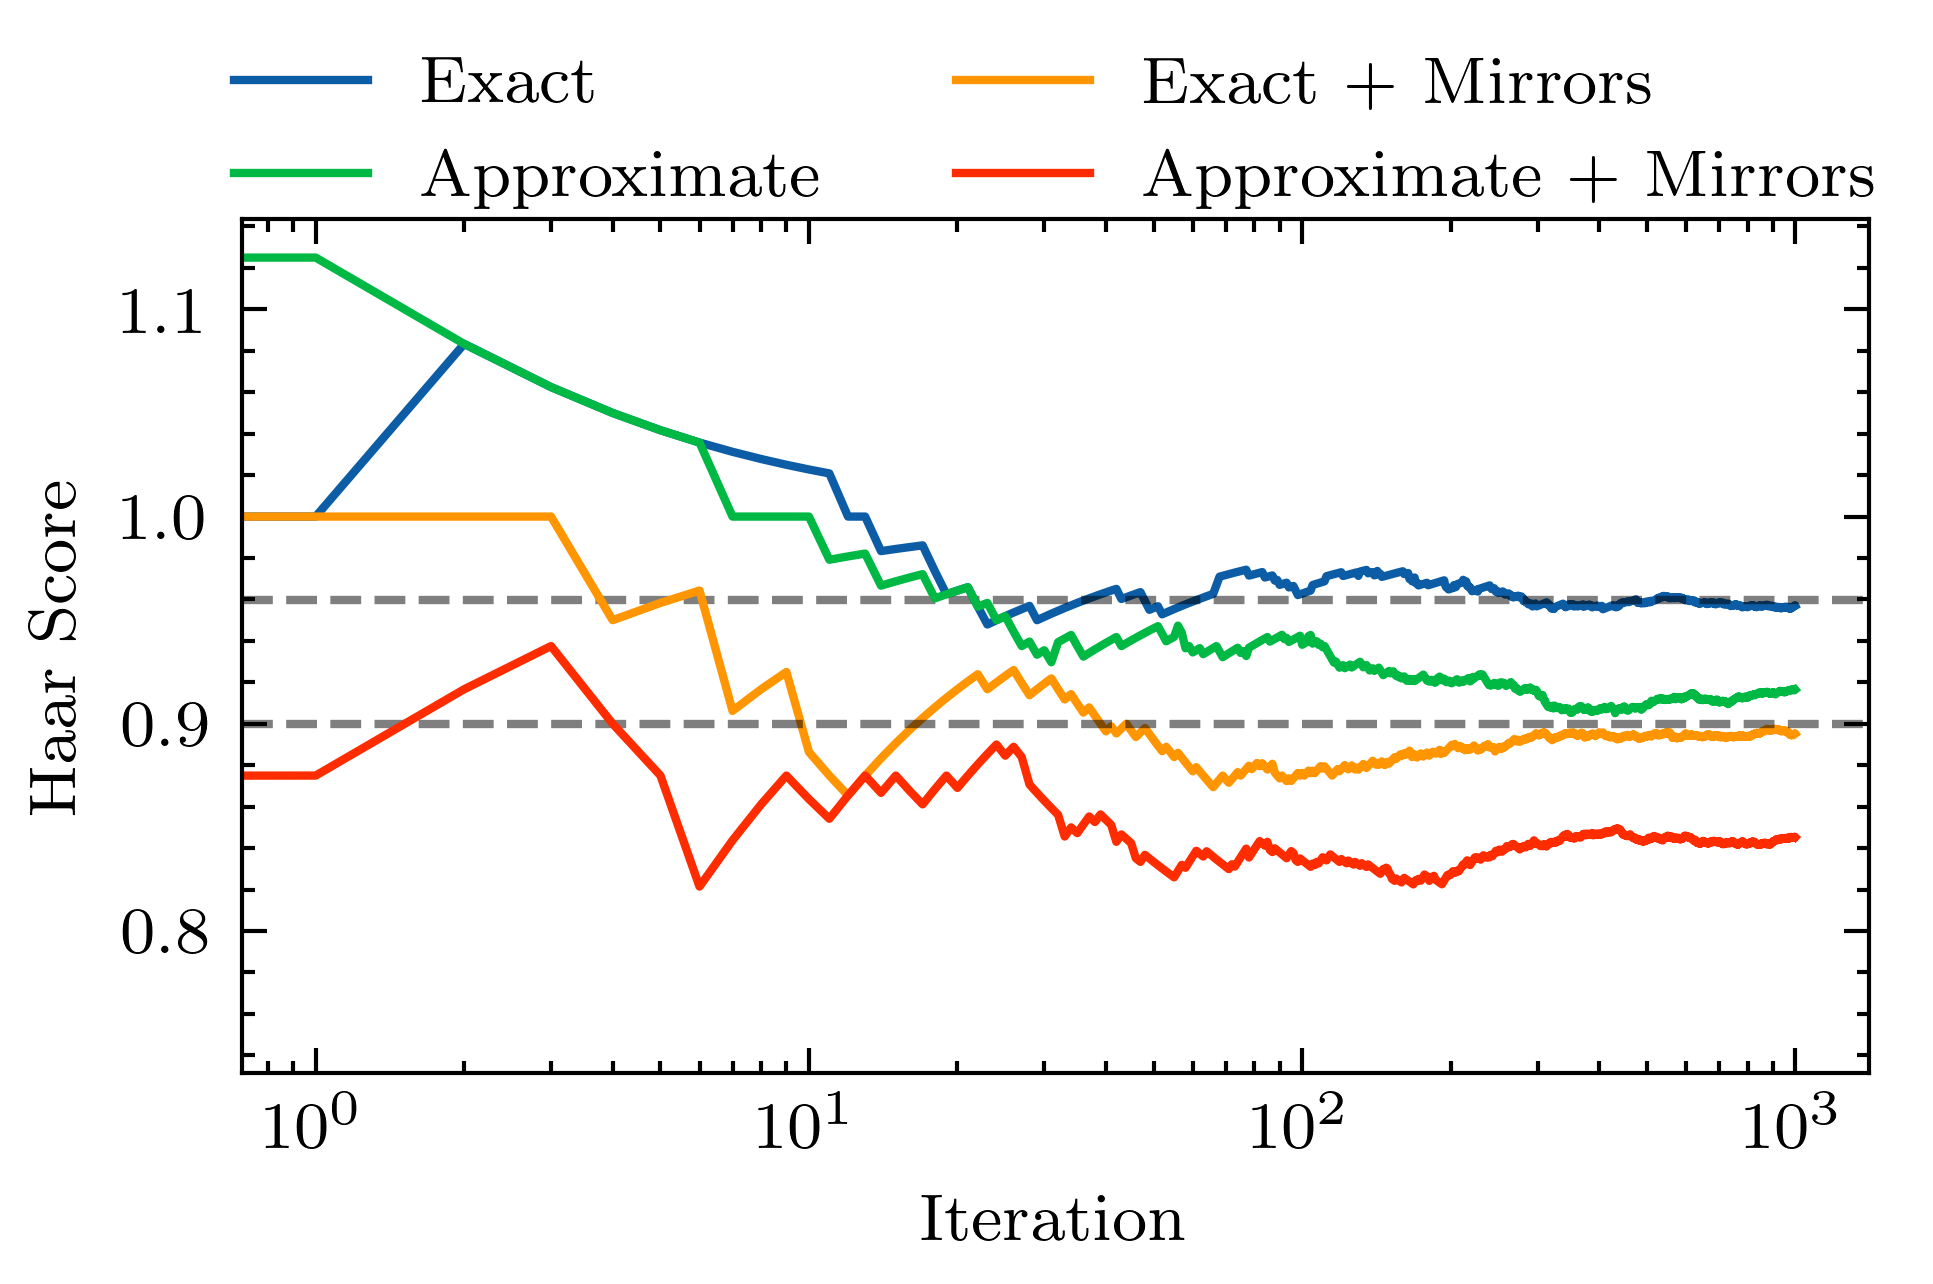

In [84]:
data = [load_hdf5_data(f"{label}.hdf5") for label in labels]

exact_convergence = {
    labels[0]: no_mirror_haar_exact,
    labels[2]: mirror_haar_exact,
}  # Replace with actual values
pretty_labels = ["Exact", "Approximate", "Exact + Mirrors", "Approximate + Mirrors"]
fig = plot_data(data, labels, pretty_labels, exact_convergence=exact_convergence)
fig.savefig(
    "weyl_mirror_sqrt[4].pdf",
    bbox_inches="tight",
    pad_inches=0,
)